In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import seaborn as sn
import xlrd
import operator
import math
import re
import openpyxl
from collections import Counter
from itertools import chain
from decimal import Decimal
from IPython.display import display, HTML
from ast import literal_eval
from pactools.grid_search import GridSearchCVProgressBar

# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import nltk
from nltk import bigrams

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\m6800\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# Importing data
df = pd.read_csv("HandelingenRutte2.csv", index_col=0)
df = df.loc[df['speech category'] == 'Main Speech']
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t for t in tokenizer.tokenize(x)]))
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > 100]
# Uitschieters weghalen.
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...


# Data Info

In [3]:
temp = df[df['party'].isin(['Vragenuur'])]
temp

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text


In [4]:
# Creates a dataframe with counts of dataset per party
countdf = df.party.value_counts()
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=False))
countdf = countdf.sort_index()
countdf

50PLUS           375
CDA             2150
ChristenUnie    1194
D66             2155
GroenLinks      1158
PVV             1783
PvdA            2220
PvdD             452
SGP              739
SP              2485
VVD             2108
Name: party, dtype: int64

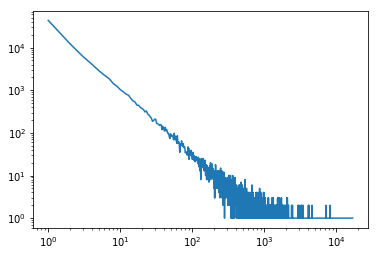

In [5]:
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

828.9328735358821


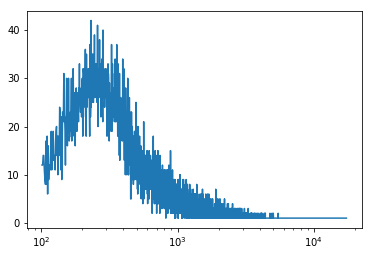

In [6]:
t = [len(doc) for doc in list_text]
meanlength = sum(t)/len(t)
print(meanlength)
t = Counter(t)
t = sorted(t.items())
x, y = zip(*t)
plt.semilogx(x, y)
plt.show()

# Baseline

In [7]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf.sum() for x in list(countdf)])
print(classification_report(df.party, simpleprediction))

              precision    recall  f1-score   support

      50PLUS       0.02      0.02      0.02       375
         CDA       0.13      0.13      0.13      2150
ChristenUnie       0.08      0.08      0.08      1194
         D66       0.14      0.14      0.14      2155
  GroenLinks       0.07      0.07      0.07      1158
         PVV       0.10      0.09      0.09      1783
        PvdA       0.13      0.13      0.13      2220
        PvdD       0.03      0.03      0.03       452
         SGP       0.06      0.06      0.06       739
          SP       0.13      0.13      0.13      2485
         VVD       0.12      0.11      0.12      2108

 avg / total       0.11      0.11      0.11     16819



In [8]:
accuracy_score(df.party, np.full(len(df.party), countdf.idxmax()))

0.14774956893988941

# Models

In [9]:
def modelsdownload(only_doen=False):
    models_df = pd.read_excel('Models.xlsx', index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [10]:
models_df, models_dict = modelsdownload(True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a   
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}

In [11]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    
    if text_dict[name]:
         text = list(df.normal_text)
    else:
        text = list(df.stemmed_text)
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_csv('Scores.csv', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_csv('Scores.csv')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [12]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_csv(file, index_col=0).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload(False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem
pipe, stem = getbestpipe('Scores.csv')
print(pipe.steps)

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=1.0,
        vocabulary=None)), ('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5.0, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [13]:
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
if stem:
    pipe.fit(df_train.stemmed_text, df_train.party)
    predicted = pipe.predict(df_test.stemmed_text)
else:
    pipe.fit(list(df_train.normal_text), list(df_train.party))
    predicted = pipe.predict(df_test.normal_text)
print(classification_report(df_test.party, predicted))
print('Accuracy: ', accuracy_score(df_test.party, predicted))

              precision    recall  f1-score   support

      50PLUS       0.98      0.90      0.94        63
         CDA       0.88      0.82      0.85       435
ChristenUnie       0.93      0.80      0.86       221
         D66       0.82      0.86      0.84       460
  GroenLinks       0.95      0.82      0.88       258
         PVV       0.89      0.93      0.91       354
        PvdA       0.79      0.78      0.79       425
        PvdD       0.97      0.94      0.96        82
         SGP       0.93      0.91      0.92       151
          SP       0.78      0.90      0.83       485
         VVD       0.82      0.80      0.81       430

 avg / total       0.85      0.85      0.85      3364

Accuracy:  0.8492865636147443


In [14]:
def mostimportantwords(pipe, countdf, filename):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = []
    for i in range(coefs.shape[0]):
        temp_list = []
        for t in coefs[i].argsort()[-10:][::-1]:
            temp_list.append(inv_vocab[t])
        top_words.append(temp_list)
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    with open("Verslag/Tables/%s1.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,:5].to_latex(index=False))
    with open("Verslag/Tables/%s2.tex" %filename, "w") as f:
        f.write(top_words.iloc[:,5:].to_latex(index=False))
    return top_words

mostimportantwords(pipe, countdf, 'MostImportantWords')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlink,pvv,de pvda,lid ouwehand nar,sgp,sp,de vvd
1,het lid krol,het cda,christenunie,led van veldhov,lid van tonger,de pvv,pvda,het lid ouwehand,de sgp,de sp,vvd
2,lid krol nar,cda fractie,lid dik faber,mijn fractie,led van tonger,islamitisch,van de arbeid,lid ouwehand,sgp fractie,sp fractie,de vvd is
3,lid krol,de cda fractie,lid dik,lid van veldhov,de led voortman,klever,de partij van,vor de dier,led van der,de sp fractie,vvd is
4,krol nar mij,de cda,het lid dik,d66 wil,led voortman,madlener nar mij,de arbeid,ouwehand nar mij,de sgp fractie,lid smaling,vvd fractie
5,krol nar,het lid omtzigt,de led voordewind,van veldhov,het lid voortman,brussel,partij van de,ouwehand nar,de led dijkgraf,het lid smaling,de vvd fractie
6,krol,lid omtzigt,led voordewind,veldhov,lid voortman,madlener nar,arbeid,ouwehand,led dijkgraf,smaling,vor de vvd
7,gepensioneerd,lid omtzigt nar,led dik,d66 is,lid voortman nar,pvv fractie,partij van,de dier,led bisschop,lid smaling nar,wat de vvd
8,van 50plus,de led geurt,led dik faber,led van men,voortman,de pvv fractie,pvda fractie,dier,de led bisschop,het lid leijt,de vvd betreft
9,lid klein nar,led geurt,de led dik,d66 vindt,van tonger,het lid madlener,de partij,de partij vor,mevrouw de voorzitter,lid leijt,vvd betreft


In [15]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

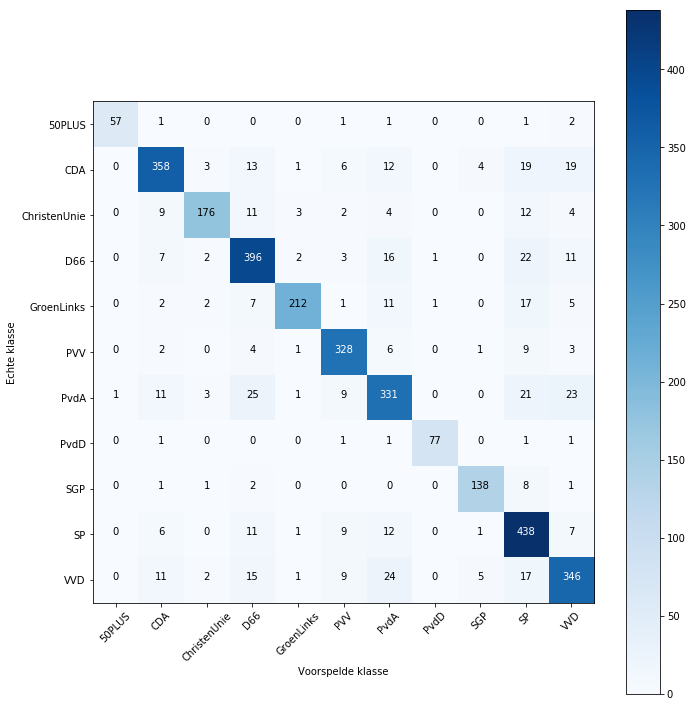

In [16]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix.png")
plt.show()

# Without Names

In [17]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
df['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
df.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,normal_text,withoutnames
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",mevrouw de voorzitter dit kabinet heeft ons mo...,Mevrouw de voorzitter Dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter vorig wek plaatst werkgever werknem...,Voorzitter Vorige week plaatsten werkgevers we...,voorzitter vorig wek plaatst werkgever werknem...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter twee maand geled kreg dit kabinet v...,Voorzitter Twee maanden geleden kreeg dit kabi...,voorzitter twee maand geled kreg dit kabinet v...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter allen al in de eerst drie maand van...,Voorzitter Alleen al in de eerste drie maanden...,voorzitter allen al in de eerst drie maand van...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",voorzitter we zijn eruit eerst ontdekt de mini...,Voorzitter We zijn eruit Eerst ontdekte de min...,voorzitter we zijn eruit eerst ontdekt de mini...


In [18]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df[df.index.isin(df_test_index)]
pipe.fit(list(df_train.withoutnames), list(df_train.party))
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

      50PLUS       0.78      0.61      0.68        66
         CDA       0.68      0.58      0.63       414
ChristenUnie       0.70      0.54      0.61       240
         D66       0.61      0.65      0.63       457
  GroenLinks       0.74      0.39      0.51       236
         PVV       0.65      0.85      0.74       346
        PvdA       0.61      0.60      0.60       452
        PvdD       0.76      0.78      0.77        91
         SGP       0.82      0.82      0.82       146
          SP       0.60      0.70      0.65       492
         VVD       0.59      0.64      0.61       424

 avg / total       0.65      0.65      0.64      3364



In [19]:
mostimportantwords(pipe, countdf, 'MostImportantWordsWithoutNames')

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,gepensioneerd,inwoner,gezinn,mijn fractie,in elk geval,islamitisch,jonger,dier,mevrouw de voorzitter,huurder,volgen mij
1,ouder,partijnaam fractie,inderdad,natur,elk geval,nederland,collega,de natur,mevrouw de,armoed,ondernemer
2,plusser,partijnaam,amendement,mijn,kamer hierover te,miljard,mijn partij,de bio,punt,zegt,aangegev
3,50 plusser,reger,dementie,hervorm,schon,brussel,gezamen,industrie,allerlei,mens,partijnaam
4,koopkrachtontwikkel,de reger,prostitutie,daarom,schon energie,de islam,circulair,milieu,wel,segregatie,partijnaam fractie
5,50,nederland spoorweg,rechtsstat,buitengewon,in elk,al,sam,de bio industrie,nadruk,bezuin,liberal
6,werkend,de nederland spoorweg,ik hop,vandag,elektrisch,asielzoeker,daarbij,bio industrie,bewindslied,herindel,volgen
7,ouderenwerklos,hier,voedselverspill,kans,zou,islam,kinder,bio,zou,bestuurder,verzekerar
8,aow,uiteind,zull,fractie,hierover te informer,belastingbetaler,ander,constater dat,oog,de bevolk,regelgev
9,vor gepensioneerd,spoorweg,ik heb,ding,belastingontwijk,natur,hun,klimaatverander,vanuit,voorstell,partijnaam is


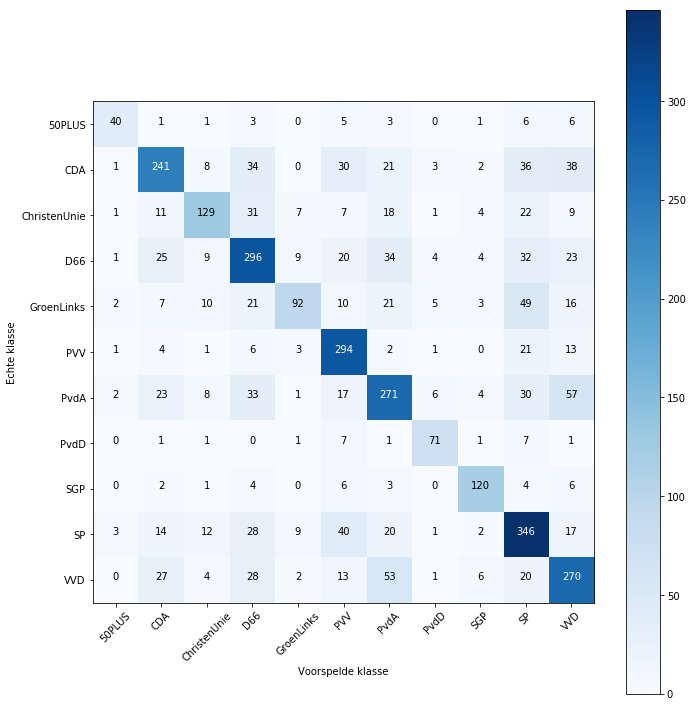

In [20]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(df_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(df.party.unique())), \
                      title='Confusion matrix best estimator')
plt.savefig("Verslag/confusionmatrix2.png")
plt.show()

# Regering & Oppositie

In [21]:
df['PartijStatus'] = df['party'].map({'CDA': 'Oppositie', 'ChristenUnie': 'Oppositie', 'D66':'Oppositie', 'SGP':'Oppositie', 'VVD':'Regering', 'SP':'Oppositie','PvdD':'Oppositie','GroenLinks':'Oppositie','PvdA':'Regering','50PLUS':'Oppositie'})
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.PartijStatus)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.PartijStatus, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


             precision    recall  f1-score   support

  Oppositie       0.83      0.96      0.89      2158
   Regering       0.85      0.49      0.62       849

avg / total       0.83      0.83      0.82      3007



In [22]:
# regering
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[-10:][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

,0
0,all
1,toezegg
2,volgen mij
3,partij
4,dar
5,de toezegg
6,tevred
7,wij
8,wellicht
9,collega


In [23]:
# oppositie
vocab = pipe.named_steps['vect'].vocabulary_
inv_vocab = {v: k for k, v in vocab.items()}
coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
top_words = []
for i in range(coefs.shape[0]):
    temp_list = []
    for t in coefs[i].argsort()[:10][::-1]:
        temp_list.append(inv_vocab[t])
    top_words.append(temp_list)
top_words = pd.DataFrame(top_words).T
top_words

,0
0,bezuin
1,kabinet
2,zou
3,staatssecretaris
4,zegt
5,mijn fractie
6,eigen
7,toch
8,waarom
9,minister


# Woorden Balkenende 4

In [24]:
# Importing data
dfb4 = pd.read_csv("HandelingenBalkenende4.csv", index_col=0)
dfb4 = dfb4.loc[dfb4['speech category'] == 'Main Speech']
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter zer vel dank vor het ver...


In [25]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

CDA             1348
ChristenUnie     674
D66              623
GroenLinks       901
PVV             1143
PvdA            1204
PvdD             215
SGP              570
SP              1499
VVD             1323
Name: party, dtype: int64

In [26]:
Party_synomyns
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)))]))
dfb4['withoutnames'] = temp.apply(lambda x: (x.replace("xxxxx",'KAMERlIDNAAM')).replace("yyyyy", 'PARTIJNAAM'))
dfb4.head(5)

,surname,party,text,file,speech category,date,tags,stemmed_text,withoutnames
5119,Marijnissen,SP,Voorzitter. Wij spreken vandaag voor het eerst...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],voorzitter wij sprek vandag vor het eerst met ...,voorzitter wij sprek vandag vor het eerst met ...
5135,Van Geel,CDA,Mevrouw de voorzitter. Er is mij gevraagd naar...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter er is mij gevraagd nar h...,mevrouw de voorzitter er is mij gevraagd nar h...
5191,Rutte,VVD,Mevrouw de voorzitter. Wij voeren vandaag een ...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter wij voer vandag een bela...,mevrouw de voorzitter wij voer vandag een bela...
5238,Tichelaar,PvdA,Mevrouw de voorzitter. Laat ik beginnen met he...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter lat ik beginn met het ni...,mevrouw de voorzitter lat ik beginn met het ni...
5275,Wilders,PVV,Mevrouw de voorzitter. Zeer veel dank voor het...,h-tk-20062007-2634-2731.xml,Main Speech,2007-03-01,['Bestuur | Organisatie en beleid'],mevrouw de voorzitter zer vel dank vor het ver...,mevrouw de voorzitter zer vel dank vor het ver...


In [27]:
pipe, _ = getbestpipe('Scores.csv')
dfb4_train = dfb4.sample(frac=0.8)
dfb4_test_index = list(set(dfb4.index.tolist()) - set(dfb4_train.index.tolist()))
dfb4_test = dfb4[dfb4.index.isin(dfb4_test_index)]
pipe.fit(list(dfb4_train.withoutnames), list(dfb4_train.party))
predicted = pipe.predict(dfb4_test.withoutnames)
print(classification_report(dfb4_test.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.59      0.63      0.61       289
ChristenUnie       0.59      0.63      0.61       131
         D66       0.79      0.54      0.64       134
  GroenLinks       0.70      0.55      0.62       167
         PVV       0.56      0.75      0.64       208
        PvdA       0.61      0.48      0.53       248
        PvdD       0.80      0.43      0.56        46
         SGP       0.79      0.77      0.78       130
          SP       0.52      0.67      0.58       282
         VVD       0.55      0.49      0.51       265

 avg / total       0.61      0.60      0.60      1900



In [28]:
mostimportantwords(pipe, countdfb4, 'MostImportantWordsWithoutNames')

,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,partijnaam fractie,fractie van partijnaam,hervorm,partijnaamfractie,burger,wet,dier,wel,zegt,onz fractie
1,wij,de fractie van,arbeidsmarkt,fractie van partijnaam,de burger,vrouw,dierproev,mijn fractie,mens,partijnaam
2,buitengewon,de fractie,schon energie,politiek,immigratie,groep,de bio,toch,lerar,partijnaam fractie
3,fractie,fractie van,woningmarkt,mij,niet,volgen mij,de bio industrie,beantwoord,bezuin,fractie
4,via,moment,welk,de fractie van,land,geweld,de veehouderij,allerlei,waarom,ondernemer
5,zorgvuld,mijn fractie,de arbeidsmarkt,fractie van,gewon,wij,de dier,helder,problem,markt
6,wij hebb,coalitieakkoord,premier,de fractie,natur,kinder,bio industrie,dankzegg vor,er,liberal
7,toezegg,verschill,hop,deal,dor,antwoord,veehouderij,positief,kritiek,kamerlidnaamman
8,kamerlidnaam,aandacht,dadelijk,klimaatverander,onz,zer,bio,diver,bureaucratie,want
9,aantal,partijnaamfractie,ik hop,premier,belastinggeld,achtergrond,japan,uitdruk,fractie dient,in elk


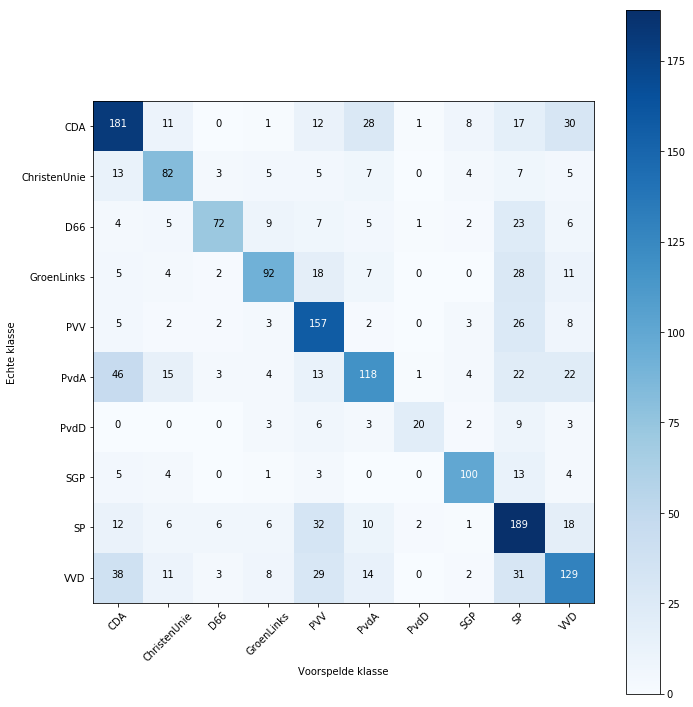

In [29]:
plt.figure(figsize=(10, 10))
cnf_matrix = confusion_matrix(dfb4_test.party, predicted)
plot_confusion_matrix(cnf_matrix, \
                      classes=sorted(list(dfb4.party.unique())), \
                      title='Confusion matrix best estimator')
plt.show()

# Vergelijken

In [30]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(tempdf.withoutnames, tempdf.party)
predicted = pipe.predict(dfb4.withoutnames)
print(classification_report(dfb4.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.31      0.28      0.29      1348
ChristenUnie       0.41      0.25      0.31       674
         D66       0.21      0.24      0.22       623
  GroenLinks       0.22      0.06      0.09       901
         PVV       0.45      0.63      0.53      1143
        PvdA       0.32      0.36      0.34      1204
        PvdD       0.58      0.55      0.56       215
         SGP       0.50      0.59      0.54       570
          SP       0.45      0.51      0.48      1499
         VVD       0.20      0.21      0.21      1323

 avg / total       0.34      0.36      0.34      9500



In [31]:
pipe, _ = getbestpipe('Scores.csv')
tempdf = df[df.party != '50PLUS']
pipe.fit(dfb4.withoutnames, dfb4.party)
predicted = pipe.predict(tempdf.withoutnames)
print(classification_report(tempdf.party, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


              precision    recall  f1-score   support

         CDA       0.22      0.32      0.26      2150
ChristenUnie       0.28      0.17      0.21      1194
         D66       0.24      0.21      0.22      2155
  GroenLinks       0.18      0.10      0.12      1158
         PVV       0.49      0.64      0.55      1783
        PvdA       0.32      0.39      0.35      2220
        PvdD       0.73      0.30      0.42       452
         SGP       0.60      0.38      0.47       739
          SP       0.39      0.49      0.44      2485
         VVD       0.21      0.13      0.16      2108

 avg / total       0.32      0.33      0.31     16444



# Links / Rechts vergelijken

In [32]:
df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})

In [ ]:
pipe, _ = getbestpipe('Scores.csv')
df_train = df.dropna().sample(frac=0.8)
df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
pipe.fit(df_train.withoutnames, df_train.Kieskompas)
predicted = pipe.predict(df_test.withoutnames)
print(classification_report(df_test.Kieskompas, predicted))

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Git

In [ ]:
!git pull
!git add CompleteNotebook.ipynb
!git add Scraper.ipynb
!git add Scores.csv
!git add Scriptie_Sprekers_TK.pdf
!git add Verslag/Tables/Spreekbeurten.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames1.tex
!git add Verslag/Tables/MostImportantWordsWithoutNames2.tex
!git add Verslag/Tables/MostImportantWords1.tex
!git add Verslag/Tables/MostImportantWords2.tex
!git add Models.xlsx
!git add Verslag/confusionmatrix.png
!git commit -m Update
!git push